In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import minmax_scale, StandardScaler
import matplotlib
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils import data
from sklearn.model_selection import train_test_split
import math
from torchinfo import summary
import torch.nn.functional as F
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter

### Getting sample from 3D block as vertical drill hole

Text(0.5, 1.0, 'Drill holes - plan view')

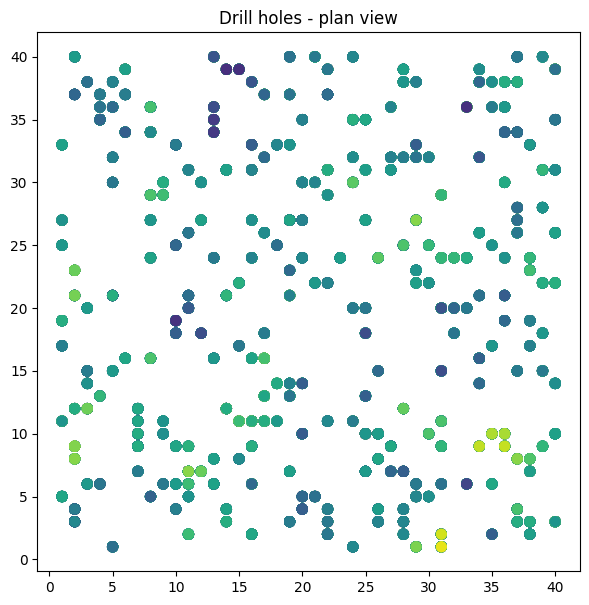

In [98]:
df_simulation = pd.read_csv('data/simulation_data.csv')

grid_size = max(df_simulation['x'].max(),df_simulation['y'].max(),df_simulation['y'].max())

numer_of_drillholes = 300

df_simulation[['x','y','z']] = df_simulation[['x','y','z']].astype(float)
x_y_grid = np.array(np.meshgrid(np.arange(1,grid_size+1,1), np.arange(1,grid_size+1,1))).T.reshape(-1,2)
df_simulation_sample = pd.DataFrame(columns=['x','y','z','finos'])
for item in np.random.default_rng().choice(x_y_grid,numer_of_drillholes):
    df_temp = df_simulation[(df_simulation['x']==item[0]) & (df_simulation['y']==item[1])]
    df_simulation_sample = pd.concat([df_temp, df_simulation_sample])



fig = plt.gcf()
fig.set_size_inches(7,7)
plt.scatter(df_simulation_sample['x'],df_simulation_sample['y'],
c=df_simulation_sample['finos'], marker='o', s=50)
plt.title('Drill holes - plan view')

In [99]:
df_simulation_sample = pd.concat([df_simulation_sample, df_simulation.sample(600)])
df_simulation_sample.drop_duplicates(inplace=True)
df_simulation_sample

,x,y,z,finos,litho,alter
18280,12.0,18.0,1.0,3.430117,Litho_B,Alter_B
18281,12.0,18.0,2.0,3.679747,Litho_B,Alter_C
18282,12.0,18.0,3.0,4.448123,Litho_B,Alter_D
18283,12.0,18.0,4.0,4.985409,Litho_B,Alter_D
18284,12.0,18.0,5.0,4.824921,Litho_B,Alter_D
...,...,...,...,...,...,...
14110,9.0,33.0,31.0,3.479739,Litho_A,Alter_D
6611,5.0,6.0,12.0,4.156929,Litho_C,Alter_D
53776,34.0,25.0,17.0,4.168505,Litho_B,Alter_C
62723,40.0,9.0,4.0,3.926693,Litho_C,Alter_C


### Creating a One Head Transformer

#### Create Training Dataset

In [150]:
df_sample = pd.get_dummies(df_simulation_sample)
df_sample = df_sample.iloc[:,:-1]
columns = df_sample.columns.tolist()
columns.remove('finos')
columns.append('finos')
df_sample = df_sample[columns]

df = pd.get_dummies(df_simulation)
df = df.iloc[:,:-1]
columns = df.columns.tolist()
columns.remove('finos')
columns.append('finos')
df = df[columns]

sc = StandardScaler()
sc.fit(df[['x','y','z']])
df[['x','y','z']] = sc.transform(df[['x','y','z']])
df_sample[['x','y','z']] = sc.transform(df_sample[['x','y','z']])

In [151]:
class Data(torch.utils.data.Dataset):
  def __init__(self, X: pd.DataFrame, y: pd.DataFrame, device) -> None:
    # need to convert float64 to float32 else
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X.to_numpy().astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.to_numpy().astype(np.float32)).to(device)
    self.len = self.X.shape[0]
  def __getitem__(self, index: int) -> tuple:
    return torch.tensor(self.X[index]).view(3,3), self.y[index]
  def __len__(self) -> int:
    return self.len


In [152]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define el tamaño de entrada, oculto y salida de la red neuronal
X = df_sample.iloc[:,:-1]
y = df_sample.iloc[:,-1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

train = Data(X_train, y_train,device)
val = Data(X_val, y_val,device)
real = Data(df.iloc[:,:-1],df.iloc[:,-1], device)

train_loader = data.DataLoader(train, batch_size=300, shuffle=True)
val_loader = data.DataLoader(val, batch_size=300)
real_loader = data.DataLoader(real)

In [153]:
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)

        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        
        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side
        
        return self.proj(y)

class TransformerBlock(torch.nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4 * n_embd),
            torch.nn.ReLU(),
            torch.nn.Linear(4 * n_embd, n_embd)
        )

    def forward(self, x):
        x = self.ln1(x + self.attn(x))
        # x = self.ln1(x)
        x = self.ln2(x + self.mlp(x))

        return x

class Model(torch.nn.Module):

    def __init__(self, n_input=3, n_embd=3, seq_len=3, n_heads=9, n_layers=1):
        super().__init__()
        self.pos_emb = torch.nn.Parameter(torch.zeros(1, seq_len, n_embd))
        self.inp_emb = torch.nn.Linear(n_input, n_embd)
        self.tranformer = torch.nn.Sequential(*[TransformerBlock(n_embd, n_heads) for _ in range(n_layers)])
        self.fc = torch.nn.Linear(n_embd*seq_len, 1)

    def forward(self, x):
        # embedding
        e = self.inp_emb(x) + self.pos_emb
        # transformer blocks
        x = self.tranformer(e) ############ ERROR AQUI
        # classifier
        y = self.fc(x.view(x.size(0), -1))
        return y


In [162]:
model = Model(n_layers=4)
model.to(device)

# Define la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# summary(model, batch_dim=50)
writer = SummaryWriter()
model.load_state_dict(torch.load('models/02Transformer_2654.pth'))
model.train(True)

Model(
  (inp_emb): Linear(in_features=3, out_features=3, bias=True)
  (tranformer): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (key): Linear(in_features=3, out_features=27, bias=True)
        (query): Linear(in_features=3, out_features=27, bias=True)
        (value): Linear(in_features=3, out_features=27, bias=True)
        (proj): Linear(in_features=27, out_features=3, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=3, out_features=12, bias=True)
        (1): ReLU()
        (2): Linear(in_features=12, out_features=3, bias=True)
      )
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (key): Linear(in_features=3, out_features=27, bias=True

In [ ]:


epoch = 0
loss_list=[]
val_list = []
while True:
    epoch = epoch+1
    # Itera a través de los datos de entrenamiento
    running_loss = 0
    running_val = 0
    for x_batch, y_btach in train_loader:
        # Predice la salida usando la red neuronal
        y_pred = model(x_batch)
        y_pred = y_pred.squeeze()
        loss = criterion(y_pred, y_btach)

        # Realiza el backpropagation y actualiza los parámetros
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss = running_loss + loss.item()
    loss_list.append(running_loss)

    # Itera a través de los datos de validación
    for x_batch, y_btach in val_loader:
        # Convierte los datos a tensores de PyTorch

        # Predice la salida usando la red neuronal
        y_pred = model(x_batch)
        y_pred = y_pred.squeeze()

        # Calcula la pérdida
        val = criterion(y_pred, y_btach)
        running_val = running_val + val.item()
    val_list.append(running_val)
    
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Validation/train", val, epoch)
    # clear_output(wait=False)
    print(f'epoch {epoch + 1}, loss {running_loss:f}')
    print(f'epoch {epoch + 1}, val {running_val:f}')
    # plt.plot(loss_list, label='loss')
    # plt.plot(val_list, label='val')
    # plt.legend()
    # plt.show()


In [145]:
torch.save(model.state_dict(), 'models/03Transformer_'+str(epoch)+'.pth')

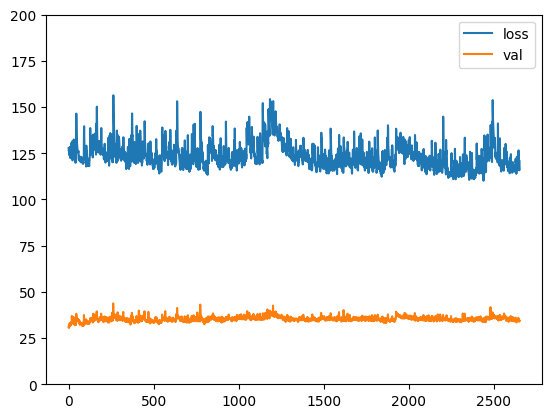

In [155]:
plt.plot(loss_list, label='loss')
plt.plot(val_list, label='val')
plt.ylim(0,200)
plt.legend()

In [ ]:
y_pred = []
y_real = []
for x_batch,y_batch in real_loader:
    y_p = model(x_batch)
    y_pred.append(y_p.item())
    y_real.append(y_batch.item())

print("r2: ", r2_score(y_real, y_pred))
print("mae: ", mean_absolute_error(y_real, y_pred))
print("mape: ", mean_absolute_percentage_error(y_real, y_pred))
plt.scatter(y_real, y_pred)

C:\Users\yair0\AppData\Local\Temp\ipykernel_12240\3896461850.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[index]).view(3,3), self.y[index]


r2:  0.14907303623053159
mae:  0.7262623660564422
mape:  0.18188053142384478


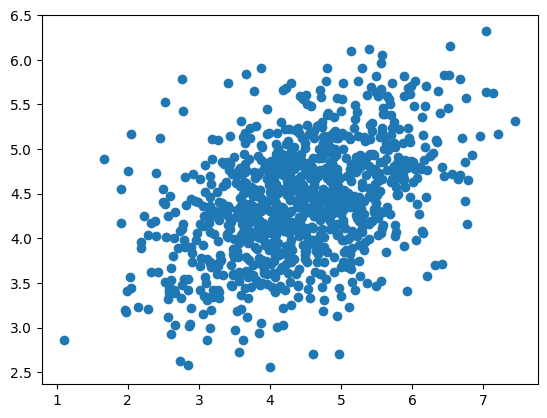

In [163]:
df_temp = df.sample(1000)
real = Data(df_temp.iloc[:,:-1],df_temp.iloc[:,-1], device)

real_loader = data.DataLoader(real)
y_pred = []
y_real = []
for x,y in real_loader:
    y_p = model(x)
    y_pred.append(y_p.item())
    y_real.append(y.item())

print("r2: ", r2_score(y_real, y_pred))
print("mae: ", mean_absolute_error(y_real, y_pred))
print("mape: ", mean_absolute_percentage_error(y_real, y_pred))
plt.scatter(y_real, y_pred)